In [129]:
!uv pip install numpy matplotlib soundfile sounddevice scipy

Using Python 3.12.10 environment at: C:\Users\heito\OneDrive\Área de Trabalho\laboratorios_rc\venv
Audited 5 packages in 5ms


In [130]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import sounddevice as sd
from scipy import signal
import time

In [131]:
# Configurações globais
SAMPLE_RATE = 44100  # Taxa de amostragem
BIT_DURATION = 1.0   # 1 segundo por bit
FREQ_LOW = 440       # Frequência para '0' (Lá)
FREQ_HIGH = 880      # Frequência para '1' (Lá oitava)

In [132]:
def show(data:str,debug):
    if debug==True:
        print(data)

In [133]:
def detect_frequency(audio_segment, sample_rate=SAMPLE_RATE):
    """
    Detecta a frequência dominante em um segmento de áudio
    
    Args:
        audio_segment: Segmento de áudio
        sample_rate: Taxa de amostragem
    
    Returns:
        float: Frequência detectada
    """
    # FFT para análise espectral
    fft = np.fft.fft(audio_segment)
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    
    # Considera apenas frequências positivas
    magnitude = np.abs(fft[:len(fft)//2])
    freqs_positive = freqs[:len(freqs)//2]
    
    # Encontra o pico de frequência
    peak_idx = np.argmax(magnitude)
    detected_freq = abs(freqs_positive[peak_idx])
    
    return detected_freq

In [134]:
def frequency_to_bit(frequency, threshold=660):
    """
    Converte frequência detectada em bit
    
    Args:
        frequency: Frequência detectada
        threshold: Limiar para decisão (média entre FREQ_LOW e FREQ_HIGH)
    
    Returns:
        str: '0' ou '1'
    """
    return '1' if frequency > threshold else '0'

In [135]:
def decode_manchester(audio_signal, num_bits, sample_rate=SAMPLE_RATE,debug=False):
    """
    Decodifica sinal Manchester
    """
    samples_per_bit = int(sample_rate * BIT_DURATION)
    decoded_bits = ""
    
    show("Decodificando Manchester:",debug)
    
    for i in range(num_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit
        
        if end_idx > len(audio_signal):
            break
        
        # Analisa primeira e segunda metade do bit
        mid_point = start_idx + samples_per_bit // 2
        
        # Primeira metade
        first_half = audio_signal[start_idx + samples_per_bit//8 : mid_point - samples_per_bit//8]
        freq1 = detect_frequency(first_half, sample_rate)
        state1 = frequency_to_bit(freq1)
        
        # Segunda metade
        second_half = audio_signal[mid_point + samples_per_bit//8 : end_idx - samples_per_bit//8]
        freq2 = detect_frequency(second_half, sample_rate)
        state2 = frequency_to_bit(freq2)
        
        # Determina o bit baseado na transição
        if state1 == '1' and state2 == '0': # Alto -> Baixo == Downclock == Bit 0
            bit = '0'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = alto->baixo = '1'",debug)
        elif state1 == '0' and state2 == '1': # Baixo -> Alto == Upclock == Bit 1
            bit = '1'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = baixo->alto = '0'",debug)
        else: # Erro de decodificação
            bit = '?'  
            show(f"Bit {i}: {freq1:.1f}Hz -> {freq2:.1f}Hz = ERRO na transição",debug)
        
        decoded_bits += bit
    
    return decoded_bits

# Etapa 2

In [136]:
audio, _ = sf.read('dados_123110811_44100hz.wav')
audio_duration = len(audio) / SAMPLE_RATE
n_bits = int(audio_duration / BIT_DURATION)
bits = decode_manchester(audio, n_bits)
print(f"Manchester: {bits}")

Manchester: 00000011110111011110


## Perguntas

- 2.1: Ruído, interferência, taxa de transmissão muito alta e baixa qualidade de hardware (microfones ou caixas de som).
- 2.2: O tempo de detecção de cada frequência fica menor, diminuindo o tempo para cada bit, resultando em detecções incorretas. 
- 2.3: Define um limite entre as frequências (660Hz) e classifica como bit 0 se a frequência for abaixo desse limite ou bit 1 se for acima. 

- A2.1: Manchester
- A2.2: 20
- A2.3: 00000011110111011110

# Etapa 3

In [137]:
def adicionar_ruido(audio_signal, snr_db=-12):
    """
    Adiciona ruído gaussiano ao sinal
    
    Args:
        audio_signal: Sinal original
        snr_db: Relação sinal-ruído em dB
    
    Returns:
        array: Sinal com ruído
    """
    # Calcula potência do sinal
    signal_power = np.mean(audio_signal ** 2)
    
    # Calcula potência do ruído baseada no SNR
    snr_linear = 10 ** (snr_db / 10)
    noise_power = signal_power / snr_linear
    
    # Gera ruído gaussiano
    noise = np.random.normal(0, np.sqrt(noise_power), len(audio_signal))
    
    return audio_signal + noise

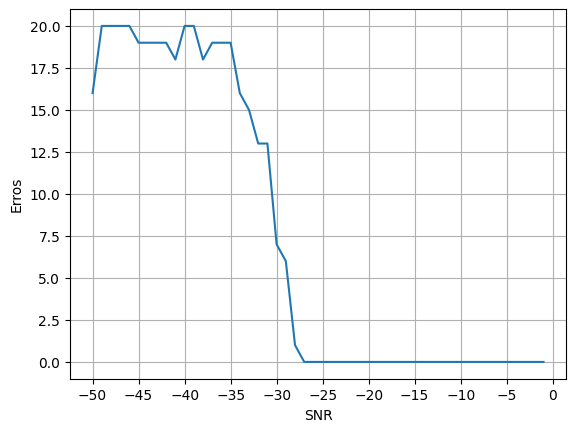

In [184]:
snr_values = np.arange(-50, 0)
errors = []

for snr in snr_values:
    noisy = adicionar_ruido(audio, snr)
    noisy_decoded = decode_manchester(noisy, n_bits)
    error_count = sum(b1 != b2 for b1,b2 in zip(bits, noisy_decoded))
    errors.append(error_count)

plt.plot(snr_values, errors)
plt.xlabel("SNR")
plt.ylabel("Erros")
plt.locator_params(axis='x', nbins='20')
plt.grid()
plt.show()

- A3.1
    - a) Os primeiros bits são comprometidos em um ruído de aproximadamente 27db.
    - b) Todos os bits são comprometidos a partir de 39db de ruído.

# Etapa 4

In [185]:
def capturar_do_microfone(duracao_segundos):
    """
    Captura áudio do microfone
    
    Args:
        duracao_segundos: Duração da captura
    
    Returns:
        array: Áudio capturado
    """
    print(f"Iniciando captura por {duracao_segundos} segundos...")
    print("Reproduza o áudio no seu celular AGORA!")
    
    # Captura áudio
    audio_capturado = sd.rec(
        int(duracao_segundos * SAMPLE_RATE), 
        samplerate=SAMPLE_RATE, 
        channels=1
    )
    sd.wait()  # Aguarda terminar a captura
    
    print("Captura concluída!")
    return audio_capturado.flatten()

In [202]:
output_device = 2
input_device = 8
sd.default.device = (input_device, output_device)

In [ ]:
duracao = 5 * BIT_DURATION + 1  # +1 segundo de margem
audio_capturado = capturar_do_microfone(duracao)

# Salva captura para análise
sf.write('captura_microfone.wav', audio_capturado, SAMPLE_RATE)

# Tenta decodificar
print("\nTentando decodificar...")
decoded = decode_manchester(audio_capturado, 5)

print(f"Original: ?????")
print(f"Capturado: {decoded}")

Iniciando captura por 6.0 segundos...
Reproduza o áudio no seu celular AGORA!
Captura concluída!

Tentando decodificar...
Original: ?????
Capturado: 01001


- 4.1: 01001
- 4.2: 1